<a href="https://colab.research.google.com/github/JSA-V/freeCodeCamp-projects/blob/main/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2022-11-16 18:19:30--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  13.2MB/s    in 1.9s    

2022-11-16 18:19:32 (13.2 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

           user         isbn  rating
0        276725   034545104X     0.0
1        276726   0155061224     5.0
2        276727   0446520802     0.0
3        276729   052165615X     3.0
4        276729   0521795028     6.0
...         ...          ...     ...
1149775  276704   1563526298     9.0
1149776  276706   0679447156     0.0
1149777  276709   0515107662    10.0
1149778  276721   0590442449    10.0
1149779  276723  05162443314     8.0

[1149780 rows x 3 columns]


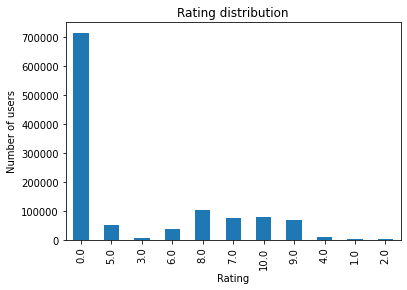

In [ ]:
# NOT ESSENTIAL

print(df_ratings)

df_ratings.rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.ylabel('Number of users')
plt.show()

In [ ]:
# NOT ESSENTIAL

print(df_ratings['isbn'].value_counts())
average_rating = pd.DataFrame(df_ratings.groupby('isbn')['rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(df_ratings.groupby('isbn')['rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

0971880107     2502
0316666343     1295
0385504209      883
0060928336      732
0312195516      723
               ... 
1568656386        1
1568656408        1
1569551553        1
1570081808        1
05162443314       1
Name: isbn, Length: 340556, dtype: int64


,rating,ratingCount
isbn,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


In [ ]:
user_counts = df_ratings['user'].value_counts()
ratings = df_ratings[df_ratings['user'].isin(user_counts[user_counts >= 200].index)]
book_counts =df_ratings['isbn'].value_counts() # with df_ or not? 
ratings = ratings[ratings['isbn'].isin(book_counts[book_counts >= 100].index)]
print(ratings.shape)

#book_counts = df_ratings['isbn'].value_counts()
#p=df_ratings['user'].isin(user_counts[user_counts >= 200].index)
#q=df_ratings['isbn'].isin(book_counts[book_counts >= 100].index)
#ratings = df_ratings[p&q]
#print(ratings.shape)

#print(ratings['isbn'].value_counts())
#print(df_ratings['isbn'].value_counts().loc['0671027344'])
#ratings.loc[1147441]
#0671027344   
#print(df_ratings['user'].value_counts().loc[275970])
#print(df_ratings['isbn'].value_counts().loc['1400031362'])
#ratings

(49781, 3)


In [ ]:
# NOT ESSENTIAL

ratings_pivot = ratings.pivot(index='user', columns='isbn').rating
user = ratings_pivot.index
isbn = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot

(888, 731)


isbn,002542730X,0060008032,0060096195,006016848X,0060173289,0060175400,006019491X,0060199652,0060391626,0060392452,...,1558744630,1558745157,1559029838,1573225517,1573225789,1573227331,1573229326,1573229571,1592400876,1878424319
user,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277427,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# NOT ESSENTIAL

bones_ratings = ratings_pivot['0316666343']
#print(bones_ratings)
similar_to_bones = ratings_pivot.corrwith(bones_ratings)
#print(similar_to_bones)
corr_bones = pd.DataFrame(similar_to_bones, columns=['pearsonR'])
#print(corr_bones)
corr_bones.dropna(inplace=True)
corr_summary = corr_bones.join(average_rating['ratingCount'])
corr_summary[corr_summary['ratingCount']>=300].sort_values('pearsonR', ascending=False).head(10)

,pearsonR,ratingCount
isbn,,
0316666343,1.000000,1295
0312291639,0.471872,354
0316601950,0.434248,568
0446610038,0.429712,391
0446672211,0.421478,585
0385265700,0.351635,319
0345342968,0.316922,321
0060930535,0.309860,494
0375707972,0.308145,354


In [ ]:
combine_book_rating = pd.merge(ratings, df_books, on='isbn')
combine_book_rating = combine_book_rating.drop([ 'author'], axis=1)
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['title'])
combine_book_rating

,user,isbn,rating,title
0,277427,002542730X,10.000,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0.000,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6.000,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10.000,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0.000,Politically Correct Bedtime Stories: Modern Ta...
...,...,...,...,...
49512,238864,0399149325,0.000,Portrait of a Killer: Jack the Ripper -- Case ...
49513,251843,0399149325,1.000,Portrait of a Killer: Jack the Ripper -- Case ...
49514,253821,0399149325,0.000,Portrait of a Killer: Jack the Ripper -- Case ...
49515,265115,0399149325,0.000,Portrait of a Killer: Jack the Ripper -- Case ...


In [ ]:
# add your code here - consider creating a new cell for each section of code

book_rating = combine_book_rating.drop_duplicates(['user', 'title'])
book_rating_pivot = book_rating.pivot(index = 'title', columns = 'user', values = 'rating').fillna(0)
A = csr_matrix(book_rating_pivot.values)

#model
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(A)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# function to return recommended books - this will be tested

def get_recommends(book = ""):
  #query_index=book_rating_pivot.index.get_loc("The Queen of the Damned (Vampire Chronicles (Paperback))")
  recommended_books=[book,[]]
  a=np.array(book_rating_pivot.loc[book]).reshape(1,-1)
  distances, indices = model_knn.kneighbors(a, n_neighbors = 6)
  distances=distances.flatten()[:0:-1]
  indices=indices.flatten()[:0:-1]
  for i,d in zip(indices,distances):
    recommended_books[1].append([book_rating_pivot.index[i],d])
  return recommended_books

get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")
#get_recommends("The Lovely Bones: A Novel")



['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [['Catch 22', 0.7939835],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.74486566],
  ['Interview with the Vampire', 0.73450685],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.51784116]]]

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
